In [1]:
# show mutiple df func
from IPython.display import display_html
from itertools import chain,cycle
def display_side_by_side(*args,titles=cycle([''])):
    html_str=''
    for df,title in zip(args, chain(titles,cycle(['</br>'])) ):
        html_str+='<th style="text-align:center"><td style="vertical-align:top">'
        html_str+=f'<h2>{title}</h2>'
        html_str+=df.to_html().replace('table','table style="display:inline"')
        html_str+='</td></th>'
    display_html(html_str,raw=True)

### 
1. yield data in
2. EWMA Chart
3. Grouping by yield(good/ok/ng)
4. KSS process for each group
5. Visualization

### Loading Data

In [74]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Lasso, LassoCV
from sklearn import ensemble
from sklearn.preprocessing import StandardScaler
from kneed import KneeLocator
import time
import datetime
import matplotlib.pyplot as plt
import statistics

panel_yield = pd.read_csv('panel_yield.csv', index_col=0)
panel_yield = panel_yield.sort_values(by="SHEET_STIME")
panel_yield = panel_yield.reset_index(drop=True)
panel_yield

,OP_NO,abbr,tft_side,LOT_ID,SHEET_ID,SHEET_STIME,INS_DATE,INS_WEEK,yield
0,3259,EE,1,EE12G10WY0,EE01NB2V60P01,2022/2/11 18:50,2022/2/11,2022W06,0.770833
1,3259,EE,1,EE12G10WY0,EE01NB2V60P02,2022/2/11 19:09,2022/2/11,2022W06,0.729167
2,3259,EE,1,EE12G10WY0,EE01NB2V60P03,2022/2/11 19:28,2022/2/11,2022W06,0.750000
3,3259,EE,1,EE12G10WY0,EE01NB2V60P04,2022/2/11 19:47,2022/2/11,2022W06,0.854167
4,3259,EE,1,EE12G10WY0,EE01NB2V60P05,2022/2/11 20:06,2022/2/11,2022W06,0.812500
...,...,...,...,...,...,...,...,...,...
199,3259,EE,1,EE12G10SY1,EE01NC0980P04,2022/2/16 01:38,2022/2/16,2022W07,0.812500
200,3259,EE,1,EE12G10SY1,EE01NC0980P05,2022/2/16 01:59,2022/2/16,2022W07,0.812500
201,3259,EE,1,EE12G10SY1,EE01NC0980P06,2022/2/16 02:21,2022/2/16,2022W07,0.812500
202,3259,EE,1,EE12G10SY1,EE01NC0980P07,2022/2/16 02:43,2022/2/16,2022W07,0.854167


### EWMA

,OP_NO,abbr,tft_side,LOT_ID,SHEET_ID,SHEET_STIME,INS_DATE,INS_WEEK,yield,ewm_value,...,long_window_std,short_window_std,short_UCL,short_LCL,long_UCL,long_LCL,long_ewma_over,long_ewma_under,short_ewma_over,short_ewma_under
0,3259,EE,1,EE12G10WY0,EE01NB2V60P01,2022/2/11 18:50,2022/2/11,2022W06,0.770833,0.770833,...,0.000000,0.000000,0.770833,0.770833,0.770833,0.770833,NaN,NaN,NaN,NaN
1,3259,EE,1,EE12G10WY0,EE01NB2V60P02,2022/2/11 19:09,2022/2/11,2022W06,0.729167,0.766667,...,0.029463,0.029463,0.758839,0.741161,0.758839,0.741161,NaN,0.729167,NaN,0.729167
2,3259,EE,1,EE12G10WY0,EE01NB2V60P03,2022/2/11 19:28,2022/2/11,2022W06,0.750000,0.765000,...,0.020833,0.020833,0.758409,0.741591,0.758409,0.741591,NaN,NaN,NaN,NaN
3,3259,EE,1,EE12G10WY0,EE01NB2V60P04,2022/2/11 19:47,2022/2/11,2022W06,0.854167,0.773917,...,0.054791,0.054791,0.801854,0.750229,0.801854,0.750229,0.854167,NaN,0.854167,NaN
4,3259,EE,1,EE12G10WY0,EE01NB2V60P05,2022/2/11 20:06,2022/2/11,2022W06,0.812500,0.777775,...,0.050173,0.050173,0.809393,0.757273,0.809393,0.757273,0.812500,NaN,0.812500,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,3259,EE,1,EE12G10SY1,EE01NC0980P04,2022/2/16 01:38,2022/2/16,2022W07,0.812500,0.801764,...,0.105615,0.070576,0.884883,0.787736,0.864356,0.718977,NaN,NaN,NaN,NaN
200,3259,EE,1,EE12G10SY1,EE01NC0980P05,2022/2/16 01:59,2022/2/16,2022W07,0.812500,0.802838,...,0.105595,0.065724,0.887496,0.797028,0.866327,0.720975,NaN,NaN,NaN,NaN
201,3259,EE,1,EE12G10SY1,EE01NC0980P06,2022/2/16 02:21,2022/2/16,2022W07,0.812500,0.803804,...,0.103819,0.066350,0.881975,0.790645,0.870064,0.727158,NaN,NaN,NaN,NaN
202,3259,EE,1,EE12G10SY1,EE01NC0980P07,2022/2/16 02:43,2022/2/16,2022W07,0.854167,0.808840,...,0.104494,0.066350,0.881975,0.790645,0.872513,0.728678,NaN,NaN,NaN,NaN


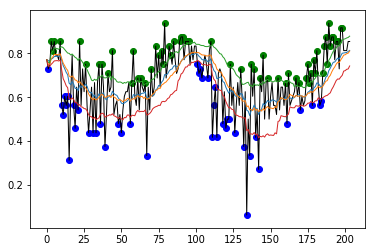

In [77]:
def ewma(panel_yield, L=3, a=0.1, long_window=21, short_window=7, plot = "short"):
    df = pd.DataFrame()
    df['data'] = panel_yield['yield']
    data = panel_yield['yield']
    ewm = []
    
    # ewma value
    for i in range(len(data.tolist())):
        if i == 0:
            ewm.append(data[i])
            continue
        tmp = a*data[i] + (1-a)*ewm[i-1]
        ewm.append(tmp)
    df['ewm_value'] = ewm
    
    mean_long = []
    mean_short = []
    std_long = []
    std_short = []
    long_center_line = []
    short_center_line = []

    # imputation of mean & std value
    for i in range(len(data)):
        if i < long_window-1:
            mean_long.append(data[0:(i+1)].mean())
            std_long.append(data[0:(i+1)].std())

        if i < short_window-1:
            mean_short.append(data[0:(i+1)].mean())
            std_short.append(data[0:(i+1)].std())
    
    # center_line
    long_center_line = data.rolling(long_window).mean().tolist()
    long_center_line[:long_window-1] = mean_long
    df['long_center_line'] = long_center_line
    short_center_line = data.rolling(short_window).mean().tolist()
    short_center_line[:short_window-1] = mean_short
    df['short_center_line'] = short_center_line
    
    # std value
    long_window_std = data.rolling(long_window).std().tolist()
    long_window_std[:long_window-1] = std_long
    long_window_std[0] = 0
    df['long_window_std'] = long_window_std
    short_window_std = data.rolling(short_window).std().tolist()
    short_window_std[:short_window-1] = std_short
    short_window_std[0] = 0
    df['short_window_std'] = short_window_std
    
    # UCL&LCL(short)
    tmp_short_ucl = []
    tmp_short_lcl = []
    for i in range(len(data)):
        tmp_short_ucl.append(df.short_center_line.tolist()[i] + L*df.short_window_std.tolist()[i]*(((a/(2-a)*(1-(1-a)**(2*i))))**0.5))
        tmp_short_lcl.append(df.short_center_line.tolist()[i] - L*df.short_window_std.tolist()[i]*(((a/(2-a)*(1-(1-a)**(2*i))))**0.5))
    
    df['short_UCL'] = tmp_short_ucl
    df['short_LCL'] = tmp_short_lcl
     
    # UCL&LCL(long)
    tmp_long_ucl = []
    tmp_long_lcl = []
    for i in range(len(data)):
        tmp_long_ucl.append(df.long_center_line.tolist()[i] + L*df.long_window_std.tolist()[i]*(((a/(2-a)*(1-(1-a)**(2*i))))**0.5))
        tmp_long_lcl.append(df.long_center_line.tolist()[i] - L*df.long_window_std.tolist()[i]*(((a/(2-a)*(1-(1-a)**(2*i))))**0.5))
    
    df['long_UCL'] = tmp_long_ucl
    df['long_LCL'] = tmp_long_lcl

    # out spec counting
    df['long_ewma_over'] = [df.data.tolist()[x] if (df.data.tolist()[x] - df.long_UCL.tolist()[x]) >= 0 else np.nan for x in range(len(df.data.tolist()))]
    df['long_ewma_over'][0] = np.nan
    df['long_ewma_under'] = [df.data.tolist()[x] if (df.data.tolist()[x] - df.long_LCL.tolist()[x]) <= 0 else np.nan for x in range(len(df.data.tolist()))]
    df['long_ewma_under'][0] = np.nan
    df['short_ewma_over'] = [df.data.tolist()[x] if (df.data.tolist()[x] - df.short_UCL.tolist()[x]) >= 0 else np.nan for x in range(len(df.data.tolist()))]
    df['short_ewma_over'][0] = np.nan
    df['short_ewma_under'] = [df.data.tolist()[x] if (df.data.tolist()[x] - df.short_LCL.tolist()[x]) <= 0 else np.nan for x in range(len(df.data.tolist()))]
    df['short_ewma_under'][0] = np.nan
    

    df = df.loc[:, df.columns!='data']
    data = pd.concat([panel_yield, df], axis=1)
    
     # show plot
    if plot == 'long':
        plt.plot(data['yield'],linewidth = '1', color='black')
        plt.plot(data['ewm_value'],linewidth = '1')
        plt.plot(data['long_center_line'],linewidth = '1')
        plt.plot(data['long_UCL'],linewidth = '1')
        plt.plot(data['long_LCL'],linewidth = '1')
        plt.scatter(y= data['long_ewma_under'].tolist(), x = data.index.tolist(),color="blue")
        plt.scatter(y= data['long_ewma_over'].tolist(), x = data.index.tolist(),color="green")
    
    if plot == 'short':
        plt.plot(data['yield'],linewidth = '1', color='black')
#         plt.plot(data['ewm_value'],linewidth = '1')
        plt.plot(data['short_center_line'],linewidth = '1')
        plt.plot(data['short_UCL'],linewidth = '1')
        plt.plot(data['short_LCL'],linewidth = '1')
        plt.scatter(y= data['short_ewma_under'].tolist(), x = data.index.tolist(),color="blue")
        plt.scatter(y= data['short_ewma_over'].tolist(), x = data.index.tolist(),color="green")
    return data

# get EWMA result
ewma_df = ewma(panel_yield=panel_yield, L=3, a=0.1, long_window=21, short_window=7, plot = "long")
# ewma_df.to_csv('ewma_df.csv')
ewma_df

### group by EWMA result

C:\Users\BarryShih\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\BarryShih\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


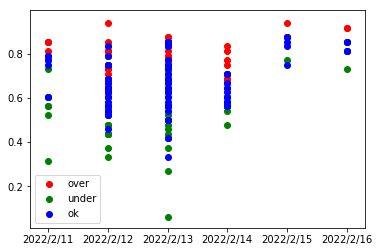

,OP_NO,abbr,tft_side,LOT_ID,SHEET_ID,SHEET_STIME,INS_DATE,INS_WEEK,yield,ewm_value,long_center_line,short_center_line,long_window_std,short_window_std,short_UCL,short_LCL,long_UCL,long_LCL,long_ewma_over,long_ewma_under,short_ewma_over,short_ewma_under,df_type
0,3259,EE,1,EE12G10WY0,EE01NB2V60P01,2022/2/11 18:50,2022/2/11,2022W06,0.770833,0.770833,0.770833,0.770833,0.000000,0.000000,0.770833,0.770833,0.770833,0.770833,NaN,NaN,NaN,NaN,ok
2,3259,EE,1,EE12G10WY0,EE01NB2V60P03,2022/2/11 19:28,2022/2/11,2022W06,0.750000,0.765000,0.750000,0.750000,0.020833,0.020833,0.758409,0.741591,0.758409,0.741591,NaN,NaN,NaN,NaN,ok
6,3259,EE,1,EE12G10WY0,EE01NB2V60P07,2022/2/11 20:44,2022/2/11,2022W06,0.791667,0.786039,0.794643,0.794643,0.048753,0.048753,0.823066,0.766220,0.823066,0.766220,NaN,NaN,NaN,NaN,ok
7,3259,EE,1,EE12G10WY0,EE01NB2V60P08,2022/2/11 21:03,2022/2/11,2022W06,0.791667,0.786602,0.794271,0.797619,0.045148,0.047681,0.826438,0.768800,0.821559,0.766982,NaN,NaN,NaN,NaN,ok
14,3588,EB,1,EB12G10AY0,ED01NB5A90P11,2022/2/11 23:19,2022/2/11,2022W06,0.604167,0.702486,0.722222,0.639881,0.118026,0.123670,0.722739,0.557022,0.801299,0.643145,NaN,0.604167,NaN,NaN,ok
16,3588,EB,1,EB12G10AY0,ED01NB5A90P09,2022/2/11 23:58,2022/2/11,2022W06,0.604167,0.657555,0.691176,0.538690,0.150093,0.104464,0.609342,0.468039,0.792689,0.589664,NaN,NaN,NaN,NaN,ok
18,3588,EB,1,EB12G10AY0,ED01NB5A90P07,2022/2/12 00:40,2022/2/12,2022W06,0.562500,0.660120,0.689693,0.577381,0.146640,0.140639,0.673079,0.481683,0.789475,0.589911,NaN,0.562500,NaN,NaN,ok
19,3588,EB,1,EB12G10AY0,ED01NB5A90P06,2022/2/12 01:00,2022/2/12,2022W06,0.458333,0.639941,0.678125,0.556548,0.151816,0.146681,0.656575,0.456520,0.781654,0.574596,NaN,0.458333,NaN,NaN,ok
20,3588,EB,1,EB12G10AY0,ED01NB5B80P26,2022/2/12 01:20,2022/2/12,2022W06,0.645833,0.640530,0.676587,0.568452,0.148139,0.150575,0.671316,0.465588,0.777787,0.575387,NaN,NaN,NaN,NaN,ok
21,3588,EB,1,EB12G10AY0,ED01NB5B80P25,2022/2/12 01:40,2022/2/12,2022W06,0.541667,0.630644,0.665675,0.559524,0.149286,0.149956,0.662111,0.456937,0.767803,0.563546,NaN,0.541667,NaN,NaN,ok


In [90]:
def grouping_by_ewma(df, ins_col='INS_DATE', term='short'):
    if term == 'long':
        over = 'long_ewma_over'
        under = 'long_ewma_under'
    else:
        over = 'short_ewma_over'
        under = 'short_ewma_under'
        
    over_df = df[ewma_df[over].notnull()]
    
    under_df = df[ewma_df[under].notnull()]
    
    ok_df = df
    ok_df = ok_df.append(over_df)
    ok_df = ok_df.drop_duplicates(keep=False)
    ok_df = ok_df.append(under_df)
    ok_df = ok_df.drop_duplicates(keep=False)
    
    
    ok_df['df_type'] = 'ok'
    under_df['df_type'] = 'under'
    over_df['df_type'] = 'over'
    
    
#     display_side_by_side(over_df,under_df,ok_df, titles=['over_df', 'under_df','ok_df'])
    
    scatter_over_yield = over_df.loc[:, over_df.columns=='yield']
    scatter_under_yield = under_df.loc[:, under_df.columns=='yield']
    scatter_ok_yield = ok_df.loc[:, ok_df.columns=='yield']

    f1 = plt.figure(1)
    plt.scatter(y= scatter_over_yield['yield'].tolist(), x = over_df[ins_col].tolist(),color="red", label="over")
    plt.scatter(y= scatter_under_yield['yield'].tolist(), x = under_df[ins_col].tolist(),color="green", label="under")
    plt.scatter(y= scatter_ok_yield['yield'].tolist(), x = ok_df[ins_col].tolist(),color="blue", label="ok")
    

#     f2 = plt.figure(2)
#     plt.boxplot([scatter_over_yield['yield'], scatter_under_yield['yield'], scatter_ok_yield['yield']])
#     plt.xticks([1, 2, 3], ['over', 'under', 'ok'])
    
    
    plt.legend()
    plt.show()
    
    return ok_df, under_df, over_df
ok_df, under_df, over_df = grouping_by_ewma(ewma_df, ins_col = 'INS_DATE' ,term='short')
display_side_by_side(ok_df,under_df,over_df, titles=['ok_df', 'under_df','over_df'])

### Pre-Processing for feature importance

In [128]:
def pre_process(df):
    df = df.drop(df.columns[9:], axis=1)
    df_factor = df.loc[:, df.columns!='yield']
    target_factor = df.loc[:, df.columns=='yield']

    df_factor["OP_NO"] = df_factor["OP_NO"].astype(str)
    df_factor["tft_side"] = df_factor["tft_side"].astype(str)

    # Get one hot encoding of columns 'vehicleType'
    one_hot = pd.get_dummies(df_factor[["OP_NO", "abbr", "LOT_ID", "tft_side", "INS_WEEK","INS_DATE"]])
    # Drop column as it is now encoded
    df_factor = df_factor.drop(["abbr", "LOT_ID", "OP_NO", "tft_side", "INS_WEEK","INS_DATE"],axis = 1)
    # Join the encoded df
    df_factor = df_factor.join(one_hot)

    # factor & target
    x, y = df_factor[df_factor.columns[~df_factor.columns.isin(['SHEET_ID','SHEET_STIME'])]].values, target_factor.values
    
    return x, y, df_factor


x, y, df_factor = pre_process(df=under_df)

C:\Users\BarryShih\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\BarryShih\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


### Lasso + RF + Kneedle

In [129]:
def lasso_summary(x, y):
    scaler = StandardScaler()
    y_scale = scaler.fit_transform(y.reshape(-1, 1))
    lasso_model = LassoCV(positive=True, max_iter=10000, fit_intercept=False)
    lasso_model.fit(x, y_scale)
    df_ouput = pd.DataFrame(columns=['Method', 'OPID_TOOLID', 'IndexValue']) # Declare df_ouput
    lasso_model_coef = lasso_model.coef_
    idx, names = 0, list(df_factor[df_factor.columns[~df_factor.columns.isin(['SHEET_ID','SHEET_STIME'])]].columns) 
    
    for ele in sorted(zip(map(lambda x: np.round(x, 4), lasso_model_coef), names), reverse=True, key=lambda x:abs(x[0])):
        if ele[0]==0: break
        df_ouput.loc[idx, :] = ['Lasso', ele[1], ele[0]]
        idx+=1
    return df_ouput

def rf_summary(x, y):
    forest = ensemble.RandomForestRegressor(n_estimators = 100,random_state = 11850)
    forest_fit = forest.fit(x, y)
    
    df_output = pd.DataFrame(columns=['Method', 'OPID_TOOLID', 'IndexValue']) # Declare df_output
    idx = 0
    
    for ele in sorted(zip(map(lambda x: round(x, 4), forest_fit.feature_importances_), list(df_factor[df_factor.columns[~df_factor.columns.isin(['SHEET_ID','SHEET_STIME'])]].columns)), reverse=True, key=lambda x:abs(x[0])):
        if ele[0]==0: break
        df_output.loc[idx, :] = ['RF', ele[1], ele[0]]
        idx+=1
    return df_output

def kneedle_function(kn_y_label, kn_y):
    """
    Run kneedle function.
    """
    try:
        kn_x = list(range(1, len(kn_y)+1))
        kn = KneeLocator(kn_x, kn_y, curve='convex', direction='decreasing')
        kneedle_result_ls = kn_y_label[:kn.knee]
    except:
        kneedle_result_ls = kn_y_label
    return kneedle_result_ls

def kneedle_optoolidresult_calcu(df_ls):
    """
    Output intersection of freqency of Lasso and RF results.
    """
    df_result = pd.DataFrame(columns=['Method', 'OPID_TOOLID', 'IndexValue']) ### declare df_result
    row_dict = {} ### dict of op_tool_id_name
    for df in df_ls:
        Kresult_ls = df['KneedleResult'].values.tolist()
        for factor_name in Kresult_ls:
            op_tool_id_name = factor_name
            if op_tool_id_name not in df_result['OPID_TOOLID'].values.tolist():
                ### Add row
                row_dict[op_tool_id_name] = df_result.shape[0]
                df_result.loc[df_result.shape[0], :] = ['Kneedle', op_tool_id_name, 1] 
            else:
                ### Find row and add freq
                freq_idx = df_result.columns.get_loc('IndexValue')
                df_result.iloc[row_dict[op_tool_id_name], freq_idx]+=1
    df_result = df_result.sort_values(by='IndexValue', ascending=False).reset_index(drop=True)
    return df_result


def kneedle_summary(df_ls):
    df_kneedle_result_ls = []
    for df in df_ls:
        kn_y_ls = df.iloc[:,2].values[:20]
        kn_y_label_ls = df.iloc[:,1].values[:20]
        kneedle_result_ls = kneedle_function(kn_y_label_ls, kn_y_ls) ### Kneedle Function
        df_result = pd.DataFrame(data=kneedle_result_ls, columns=['KneedleResult'])
        df_kneedle_result_ls.append(df_result)
    df_result = kneedle_optoolidresult_calcu(df_kneedle_result_ls)
    return df_result


lasso_output = lasso_summary(x,y)
rf__output = rf_summary(x,y)

tmp_weight = sum(lasso_output['IndexValue'])/len(lasso_output['IndexValue'])
weight_ls = lasso_output['IndexValue']/tmp_weight
weight_ls.name = 'weight_IndexValue'
lasso_output_1 = pd.concat([lasso_output,weight_ls],axis=1)
# lasso_output_1

tmp_weight = sum(rf__output['IndexValue'])/len(rf__output['IndexValue'])
weight1_ls = rf__output['IndexValue']/tmp_weight
weight1_ls.name = 'weight_IndexValue'
rf_output_1 = pd.concat([rf__output,weight1_ls],axis=1)
# rf_output_1

output = pd.concat([lasso_output_1, rf_output_1])
output1 = output.sort_values(by='OPID_TOOLID')
kneedle_output = kneedle_summary([lasso_output_1, rf_output_1]) 
display_side_by_side(lasso_output,rf__output,output1,kneedle_output, titles=['lasso','rf', 'lasso+rf', 'kneedle'])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\BarryShih\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


,Method,OPID_TOOLID,IndexValue
0,Lasso,abbr_EE,1.128
,Method,OPID_TOOLID,IndexValue
0,RF,abbr_EE,0.4525
1,RF,abbr_EB,0.3847
2,RF,LOT_ID_EB12G10BY0,0.0446
3,RF,INS_DATE_2022/2/12,0.0228
4,RF,INS_DATE_2022/2/14,0.0192
5,RF,LOT_ID_EB12G10CY0,0.0185
6,RF,INS_DATE_2022/2/13,0.017
7,RF,INS_DATE_2022/2/11,0.0135


In [1]:
import shap